### TO DO - Aug 22th
* solve the issue of calculation of the number of pads and number of drops, number of crops. 

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
from glob import glob
import os
import ntpath 
import zipfile

In [2]:
def reading_csv_files(folder_path):
    '''PRE-PROCESSING: reading the csv file on a particular folder'''
    
    # saving all the csv files in a dataframe
    import os
    import glob
    # glob.glob('*.csv') #find all the csv files in a pathname. 
    os.chdir(folder_path)
    csv_files = [i for i in glob.glob('*.csv')]

    # Reading each csv file and storing them in a dictionnary containing the file name and the dataframe
    dict_files={}
    files_names=[]
    for files in csv_files:
        df=pd.read_csv(files,engine='python')
        basepath, filename=ntpath.split(files)
        files_names.append(filename)
        dict_files[filename]=df

    # Calculating the # of rows and features for each dataframe and storing them in a list of tuples
    shape_df=[]
    for i in range(0,len(dict_files.keys())):
        nrows, ncols=(len(dict_files[files_names[i]]),len(dict_files[files_names[i]].columns))
        shape_df.append((nrows,ncols))

    return (shape_df,files_names,dict_files)

def number_of_patients(df):
    '''PRE_PROCESSING: return the number of patients in each csv files'''
    if 'PATNO' in df.columns:
        patients=len(list(set(df['PATNO'])))
    else: 
        patients=0
    return patients

# to change by adding the max sequence length. 
def number_of_events(df): 
    '''PRE_PROCESSING: return the number of events covered by each csv file'''
    if 'EVENT_ID' in df.columns:
        events=len(list(set(df['EVENT_ID'])))
    else: 
        events=0
    return events

def features_selection(list_df_sel):
    '''PRE PROCESSING: do features selection for each df,sel in list_df_sel'''
    return df_sel

def patients_selection(df, threshold=6):
    '''PRE-PROCESSING: return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

def padding_cropping_analysis(df,input_timesteps=4,th_drop=2):
    
    '''Return the number of crops, pads, drops to do in function of the length of the input 
    sequence and the threshold of pads allowed'''
    
    ## Write some assert statement for this function
    visits_number=df.groupby('PATNO').size().sort_values(ascending=False)

    patients_cropping=visits_number[visits_number>input_timesteps].to_frame().rename(columns=dict(zip([0],['visits_num'])))
    patients_nothing=visits_number[visits_number==input_timesteps].to_frame().rename(columns=dict(zip([0],['visits_num'])))
    patients_dropping=visits_number[visits_number<input_timesteps-th_drop].to_frame().rename(columns=dict(zip([0],['visits_num'])))
    pad_mask=((visits_number>=(input_timesteps-2)) & (visits_number<input_timesteps))
    patients_padding=visits_number[pad_mask].to_frame().rename(columns=dict(zip([0],['visits_num'])))

    patients_cropping['processing_op']='cropping'
    patients_cropping['op_num']=patients_cropping['visits_num']-(input_timesteps)
    num_crops=patients_cropping['op_num'].sum()
    
    patients_nothing['processing_op']='nothing'
    patients_nothing['op_num']=patients_nothing['visits_num']-(input_timesteps)
    
    assert patients_nothing['op_num'].sum()==0
    
    patients_dropping['processing_op']='dropping'
    patients_dropping['op_num']=(input_timesteps-2)-patients_dropping['visits_num']
    num_drops=patients_dropping['op_num'].sum()
    
    patients_padding['processing_op']='padding'
    patients_padding['op_num']=(input_timesteps)-patients_padding['visits_num']
    num_pads=patients_padding['op_num'].sum()

    df_visits=pd.concat([patients_dropping,patients_padding,patients_nothing,patients_cropping],axis=0)
  
    #operations_num=df_visits.groupby('processing_op').size()
    #index=list(operations_num.index)
    #index_values=[operations_num[i] for i in index]
    #num_pat=dict(zip(index,index_values))
    
    return (df_visits, dict(zip(['drops','pads','crops'],[num_drops,num_pads,num_crops])))

def table_analysis(list_df,df_names,threshold=6,input_timesteps=4,th_drop=2): 
    '''PRE-PROCESSING: return a dataframe with: 
    -as rows: list of df
    -as columns: 
        - total number of observations=rows
        - total number of features=columns after features_selection - features_selection function 
        - number of events
        - number of PD patients by using PRODROMA info - number_of_patients function
        - number of patients with # of visits > threshold - number_of_patients function
        - shape of final df after selections of rows and columns
        -number of NaN values in the final df
        NB: takes as input the df with features selection. 
    '''   
    # initialisation df
    col=['observations_tot','features','events_num','patients_num',
         'patients_sel','len_df_sel','drops','pads','crops','new_len','NaN_values']
    df_df=pd.DataFrame(columns=col,index=df_names)

    # remplissage of dataframe for each row
    for i,df in enumerate(list_df):
        
        df_df.iloc[i,:]['observations_tot']=len(df)
        df_df.iloc[i,:]['features']=len(df.columns)
        df_df.iloc[i,:]['events_num']=number_of_events(df)
        df_df.iloc[i,:]['patients_num']=number_of_patients(df)
        
        if not patients_selection(df)==0:
            df=patients_selection(df,threshold=threshold)[1]          
            df_df.iloc[i,:]['patients_sel']=len(set(df['PATNO']))
        else: 
            if 'PATNO' in df.columns:
                df_df.iloc[i,:]['patients_sel']=len(set(df['PATNO']))
            else:
                df_df.iloc[i,:]['patients_sel']=0            
        df_df.iloc[i,:]['len_df_sel']=len(df)
        df_df.iloc[i,:]['NaN_values']=(df.isnull().sum().sum())/(df_df.iloc[i,:]['len_df_sel']*df_df.iloc[i,:]['features'])
        
        
        if 'drops' in list(padding_cropping_analysis(df)[1].keys()):
            df_df.iloc[i,:]['drops']=padding_cropping_analysis(df,input_timesteps=input_timesteps,th_drop=th_drop)[1]['drops']
        else:
            df_df.iloc[i,:]['drops']=0
            
        if 'pads' in list(padding_cropping_analysis(df)[1].keys()):
            df_df.iloc[i,:]['pads']=padding_cropping_analysis(df,input_timesteps=input_timesteps,th_drop=th_drop)[1]['pads']
        else:
            df_df.iloc[i,:]['pads']=0
            
        if 'crops' in list(padding_cropping_analysis(df)[1].keys()):
            df_df.iloc[i,:]['crops']=padding_cropping_analysis(df,input_timesteps=input_timesteps,th_drop=th_drop)[1]['crops']
        else:
            df_df.iloc[i,:]['crops']=0
            
        df_df.iloc[i,:]['new_len']=input_timesteps*df_df.iloc[i,:]['patients_num']-df_df.iloc[i,:]['drops']

    return df_df

def INFODT_date(df):
    '''PRE_PROCESSING: add a datetime for the timeseries'''
    if 'INFODT' in df.columns: 
        df['INFODT_date']=df['INFODT'].apply(lambda x: datetime.strptime(x,'%m/%Y'))
    return df

## 1-Subject-Characteristics

In [3]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Patient_Status - actually useful for selecting only the PD patients in each table
PRODROMA=dict_files[files_names[0]]
PD_cat=['PD','REGPD','GENPD']
PD_patients=list(PRODROMA.loc[PRODROMA['RECRUITMENT_CAT'].isin(PD_cat),'PATNO'])
print('number of PD patients:{}'.format(len(PD_patients)))


### Screening__Demographics - useful
#### NOT TS DATA
SCREEN=dict_files[files_names[3]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME',
       'CONSNTDT', 'APPRDX', 'CURRENT_APPRDX', 'P3GRP', 'BIRTHDT', 'GENDER',
       'HISPLAT', 'RAINDALS', 'RAASIAN', 'RABLACK', 'RAHAWOPI', 'RAWHITE',
       'RANOS', 'PRJENRDT']
SCREEN_sel=SCREEN[SEL]
print(number_of_patients(SCREEN))

number of PD patients:1052
2144


## 5-Medical History

In [4]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Diagnostic_Features.csv': useful: Feat-PD - 1670 patients.

DIAGFEAT=dict_files[files_names[1]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'DFSTROKE', 'DFRSKFCT', 'DFPRESNT', 'DFRPROG', 'DFSTATIC', 'DFHEMPRK',
       'DFAGESX', 'DFOTHCRS', 'DFCRSCM', 'DFRTREMP', 'DFRTREMA', 'DFPATREM',
       'DFOTHTRM', 'DFTREMCM', 'DFRIGIDP', 'DFRIGIDA', 'DFAXRIG', 'DFUNIRIG',
       'DFTONE', 'DFOTHRIG', 'DFRIGCM', 'DFBRADYP', 'DFBRADYA', 'DFAKINES',
       'DFBRPLUS', 'DFOTHABR', 'DFABRCM', 'DFPGDIST', 'DFGAIT', 'DFFREEZ',
       'DFFALLS', 'DFOTHPG', 'DFPGCM', 'DFPSYCH', 'DFCOGNIT', 'DFDYSTON',
       'DFCHOREA', 'DFMYOCLO', 'DFOTHHYP', 'DFHYPCM', 'DFHEMTRO', 'DFPSHYPO',
       'DFSEXDYS', 'DFURDYS', 'DFBWLDYS', 'DFOCULO', 'DFEYELID', 'DFNEURAB',
       'DFDOPRSP', 'DFRAPSPE', 'DFBULBAR', 'DFCTSCAN', 'DFMRI', 'DFATYP']
DIAGFEAT_sel=DIAGFEAT[SEL]

### 'General_Medical_History.csv': useful: Feat-Gen - 2067 patients
#### NOT TS DATA...

MHXGEN=dict_files[files_names[3]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'MHCAT', 'MHROW', 'MHHX', 'MHACTRES', 'MHDIAGYR', 
     'PT_CODE', 'PT_NAME', 'HLT_NAME', 'SOCABBR1']
# I need probably to select less features here
MHXGEN_sel=MHXGEN[SEL]

### General_Physical_Exam: useful: Feat-Gen - 2047 patients
GENPHYEX=dict_files[files_names[5]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'PESEQ', 'PECAT', 'ABNORM']
GENPHYEX_sel=GENPHYEX[SEL]

### 'General_Neurological_Exam.csv': useful: Feat-Gen - 2048 patients
PENEURO=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'MSRARSP', 'MSRACM', 'MSLARSP', 'MSLACM', 'MSRLRSP', 'MSRLCM',
       'MSLLRSP', 'MSLLCM', 'COFNRRSP', 'COFNRCM', 'COFNLRSP', 'COFNLCM',
       'COHSRRSP', 'COHSRCM', 'COHSLRSP', 'COHSLCM', 'SENRARSP', 'SENRACM',
       'SENLARSP', 'SENLACM', 'SENRLRSP', 'SENRLCM', 'SENLLRSP', 'SENLLCM',
       'RFLRARSP', 'RFLRACM', 'RFLLARSP', 'RFLLACM', 'RFLRLRSP', 'RFLRLCM',
       'RFLLLRSP', 'RFLLLCM', 'PLRRRSP', 'PLRRCM', 'PLRLRSP', 'PLRLCM']
PENEURO_sel=PENEURO[SEL]

### 'Neurological_Exam_-_Cranial_Nerves.csv': useful: Feat-PD - 2049 patients
PENEURO2=dict_files[files_names[13]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'CN1RSP','CN2RSP', 'CN346RSP','CN5RSP',
     'CN7RSP', 'CN8RSP', 'CN910RSP',
       'CN11RSP', 'CN12RSP']
PENEURO2_sel=PENEURO2[SEL]

### 'PD_Features.csv': useful: Feat-PD - caution: these are actually not timeseries but examination only done at screening (SC), BL & V04
### 1017 patients
PDFEAT=dict_files[files_names[14]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'SXMO',
       'SXYEAR', 'PDDXDT', 'DXTREMOR', 'DXRIGID', 'DXBRADY',
       'DXPOSINS', 'DXOTHSX','DOMSIDE','DOMSIDE']
PDFEAT_sel=PDFEAT[SEL]
#list(set(PDFEAT_sel['DXOTHCM'])) - see if we remove the comment feature or not.

### 'Vital_Signs.csv': useful: Feat-Gen
### 2047 patients
VITAL=dict_files[files_names[15]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'WGTKG', 'HTCM', 'TEMPC', 'SYSSUP', 'DIASUP', 'HRSUP',
       'SYSSTND', 'DIASTND', 'HRSTND']
VITAL_sel=VITAL[SEL]

## 6-Motor-Assessments - all of them can be useful. 
* UPDRS1 assesses non-motor experiences of daily-living 
* UPDRS2P assesses motor experiences of daily living
* UPDRS3 assesses motor signs of PD. Includes Hoehn & Yahr Stage. 
* UPDRS4 assesses motor complications, dyskinesias, & moto fluctuations using historical & objective information.  

**NHY from NUPDRS3 & MODSEALG are the 2 possible targets (cat variables)**

In [5]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/6-Motor-Assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'MDS_UPDRS_Part_I__Patient_Questionnaire.csv' - 2011 patients
NUPDR1SP=dict_files[files_names[0]]

### 'MDS_UPDRS_Part_I.csv' - 2010 patients - 
NUPDRS1=dict_files[files_names[2]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
       'NP1DDS']
NUPDRS1_sel=NUPDRS1[SEL]

### 'MDS_UPDRS_Part_II__Patient_Questionnaire.csv' - 2011 patients
NUPDRS2P=dict_files[files_names[11]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'NP2SPCH', 'NP2SALV', 'NP2SWAL', 'NP2EAT', 'NP2DRES',
       'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE',
       'NP2WALK', 'NP2FREZ']
NUPDRS2P_sel=NUPDRS2P[SEL]

### 'MDS_UPDRS_Part_III.csv' - 2010 patients
NUPDRS3=dict_files[files_names[7]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'CMEDTM', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU',
       'NP3RIGLU', 'PN3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR',
       'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR',
       'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR',
       'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU',
       'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES',
       'DYSKIRAT', 'NHY', 'ANNUAL_TIME_BTW_DOSE_NUPDRS', 'ON_OFF_DOSE',
       'PD_MED_USE']
NUPDRS3_sel=NUPDRS3[SEL]

### 'MDS_UPDRS_Part_IV.csv' - 860 patients
NUPDRS4=dict_files[files_names[5]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'NP4WDYSK', 'NP4DYSKI', 'NP4OFF', 'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN']
NUPDRS4_sel=NUPDRS4[SEL]

### 'PASE_-_Household_Activity.csv' - 1248 patients
PASE=dict_files[files_names[3]]
### 'PASE_-_Leisure_Time_Activity.csv' - 1248 patients
PASELT=dict_files[files_names[10]]

### 'Modified_Schwab_+_England_ADL.csv' - 1837 patients
MODSEADL=dict_files[files_names[6]]

## 7-Non-motor-assessments - all of them can be useful but we might need to choose. 
### Do a correlation analysis and ask doctors which ones are the more relevant. 

In [6]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/7-Non-motor-assessments/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'University_of_Pennsylvania_Smell_ID_Test.csv' - 1799 patients - OLFACTION
UPSIT=dict_files[files_names[0]]
UPSIT.head()

### 'Epworth_Sleepiness_Scale.csv - 1343 patients - SLEEP. 
EPWORTH=dict_files[files_names[2]]
EPWORTH.head()

### 'Letter_-_Number_Sequencing__PD_.csv' - 1341 patients. - MEMORY. 
LNSPD=dict_files[files_names[3]]
LNSPD.head()

### 'Olfactory_UPSIT.csv' - 4468 patients - OLFACTION. 
#### NB: only take the 2 last columns as features (TOTAL_CORRECT, UPSIIT_PRCNTGE)
OLFACT=dict_files[files_names[4]]
OLFACT.head()

### 'REM_Sleep_Disorder_Questionnaire.csv' - 1810 patients - SLEEP. 
REMSLEEP=dict_files[files_names[5]]
REMSLEEP.head()

### 'Cognitive_Assessments.csv' - 1172 patients
COGTIME=dict_files[files_names[6]]
COGTIME.head()

### 'SCOPA-AUT.csv' - 1345 patients - AUTOMATIC DYSFUNCTIONS
SCOPAAUT=dict_files[files_names[7]]
SCOPAAUT.head()

### Cognitive_Categorization.csv' - 1302 patients - DEMENTIA/MILD COGNITIVE IMPAIRMENT
COGCATG=dict_files[files_names[8]]
COGCATG.head()

### 'Hopkins_Verbal_Learning_Test.csv' - 1341 patients - MEMORY
HVLT=dict_files[files_names[9]]
HVLT.head()

### 'Montreal_Cognitive_Assessment__MoCA_.csv' - 2054 patients - MILD COGNITIVE IMPAIRMENT - PD 
MOCA=dict_files[files_names[10]]
MOCA.head()

### 'Semantic_Fluency.csv' - 1342 patients - Lexical/Semantic Fluency
SFT=dict_files[files_names[11]]
SFT.head()

### 'Geriatric_Depression_Scale__Short_.csv' - 1478 patients - DEPRESSION
GDSSHORT=dict_files[files_names[12]]
GDSSHORT.head()

### 'Symbol_Digit_Modalities.csv' - 1340 patients - COGNITIVE IMPAIRMENT. 
SDM=dict_files[files_names[13]]
SDM.head()

### 'State-Trait_Anxiety_Inventory.csv' - 1474 patients - DEPRESSION
STAI=dict_files[files_names[14]]
STAI.head()

### 'Benton_Judgment_of_Line_Orientation.csv' - 1341 patients - SPATIAL PERCEPTION/ORIENTATION 
BENTONOD=dict_files[files_names[15]]
BENTONOD.head()

### 'QUIP_Current_Short.csv' - 1346 patients - COMPULSIVE DISORDERS
QUIPCS=dict_files[files_names[16]]

## 8-Medications data

In [7]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

In [8]:
### Use of PD Medication: useful: Meds - but not to be used for now.
PDMEDUSE=dict_files[files_names[4]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'PDMEDYN', 'ONLDOPA', 'ONDOPAG', 'ONOTHER', 'FULNUPDR', 'PDMEDDT',
       'PDMEDTM', 'NUPDRTM']
PDMEDUSE_sel=PDMEDUSE[SEL]

### 'Concomitant_Medications.csv': useful: Meds - no time to exploit this stuff. 
CMED=dict_files[files_names[6]]

### 'Current_Medical_Conditions_Log.csv': Meds
CURRCOND=dict_files[files_names[8]]
CURRCOND.columns
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'SEQNO',
       'CONDCAT', 'DIAGYR','CONDTERM', 'RESOLVD', 'RESYR',
       'HLGTNAME', 'HLT_NAME','PT_CODE','SOCABBR1', 'VMEDDRA']
CURRCOND_sel=CURRCOND[SEL]

### 'Surgery_for_Parkinson_Disease.csv': useful: Meds - but not to be used for now.
SURGPD=dict_files[files_names[12]]
SURGPD.columns
SEL=['REC_ID','PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'PDSURG', 'PDSURGDT', 'PDSURGTP']
SURGPD_sel=SURGPD[SEL]

## Dataset Analysis (variations of number of samples, patients)

### 1. Variation of # of samples by seg length thresold

In [9]:
list_df=[DIAGFEAT_sel,MHXGEN_sel,GENPHYEX_sel,PENEURO_sel,PENEURO2_sel,VITAL_sel,
NUPDRS1,NUPDRS2P,NUPDRS3,NUPDRS4,PASE,PASELT,MODSEADL,
UPSIT,EPWORTH,LNSPD,REMSLEEP,COGTIME,SCOPAAUT,COGCATG,HVLT,
MOCA,SFT,GDSSHORT,SDM,STAI,BENTONOD,QUIPCS,PDMEDUSE]

df_names=['DIAGFEAT','MHXGEN','GENPHYEX','PENEURO','PENEURO2','VITAL',
'NUPDRS1','NUPDRS2P','NUPDRS3','NUPDRS4','PASE','PASELT','MODSEADL',
'UPSIT','EPWORTH','LNSPD','REMSLEEP','COGTIME','SCOPAAUT','COGCATG','HVLT',
'MOCA','SFT','GDSSHORT','SDM','STAI','BENTONOD','QUIPCS','PDMEDUSE']

dataset_analysis_maintables6=table_analysis(list_df,df_names)
dataset_analysis_maintables2=table_analysis(list_df,df_names,2)
dataset_analysis_maintables4=table_analysis(list_df,df_names,4)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in long_scalars


In [10]:
def sel_for_plot(df,rowSel, colSel,num):
    df=df.loc[rowSel,colSel]
    NewCols=[c+'{}'.format(num) for c in colSel]
    colRenamed=dict(zip(colSel,NewCols))
    df.rename(columns=colRenamed,inplace=True)
    return df

rowSel=['DIAGFEAT','GENPHYEX','NUPDRS3','MODSEADL','MOCA','PDMEDUSE']
colSel=['patients_sel','len_df_sel']
df_to_plot6=sel_for_plot(dataset_analysis_maintables6,rowSel=rowSel,colSel=colSel,num=6)
df_to_plot4=sel_for_plot(dataset_analysis_maintables4,rowSel=rowSel,colSel=colSel,num=4)
df_to_plot2=sel_for_plot(dataset_analysis_maintables2,rowSel=rowSel,colSel=colSel,num=2)

df_to_plot=pd.merge(df_to_plot2,df_to_plot4,left_index=True,right_index=True)
df_to_plot=pd.merge(df_to_plot,df_to_plot6,left_index=True,right_index=True)
df_to_plot=df_to_plot.T
df_to_plot['Measure']=list(np.tile(('len_patients','len_df_sel'),3))
df_to_plot['Visits_threshold']=list(np.repeat((2,4,6),2))

def select_measure(df,rowSel): 
    df=df.loc[rowSel,:]
    df.drop(columns='Measure',inplace=True)
    df.rename(index=dict(zip(list(df.index),list(df['Visits_threshold'].values))),inplace=True)
    df.drop(columns='Visits_threshold',inplace=True)
    return df

dfPlot_patients=select_measure(df_to_plot,['patients_sel2','patients_sel4','patients_sel6'])
dfPlot_patients

dfPlot_samples=select_measure(df_to_plot,['len_df_sel2','len_df_sel4','len_df_sel6'])
dfPlot_samples

,DIAGFEAT,GENPHYEX,NUPDRS3,MODSEADL,MOCA,PDMEDUSE
2,5243,24382,12125,9606,5393,6518
4,4169,24382,11322,8811,4093,6294
6,2349,24382,10440,7985,2824,5873


In [13]:
!pip install cufflinks

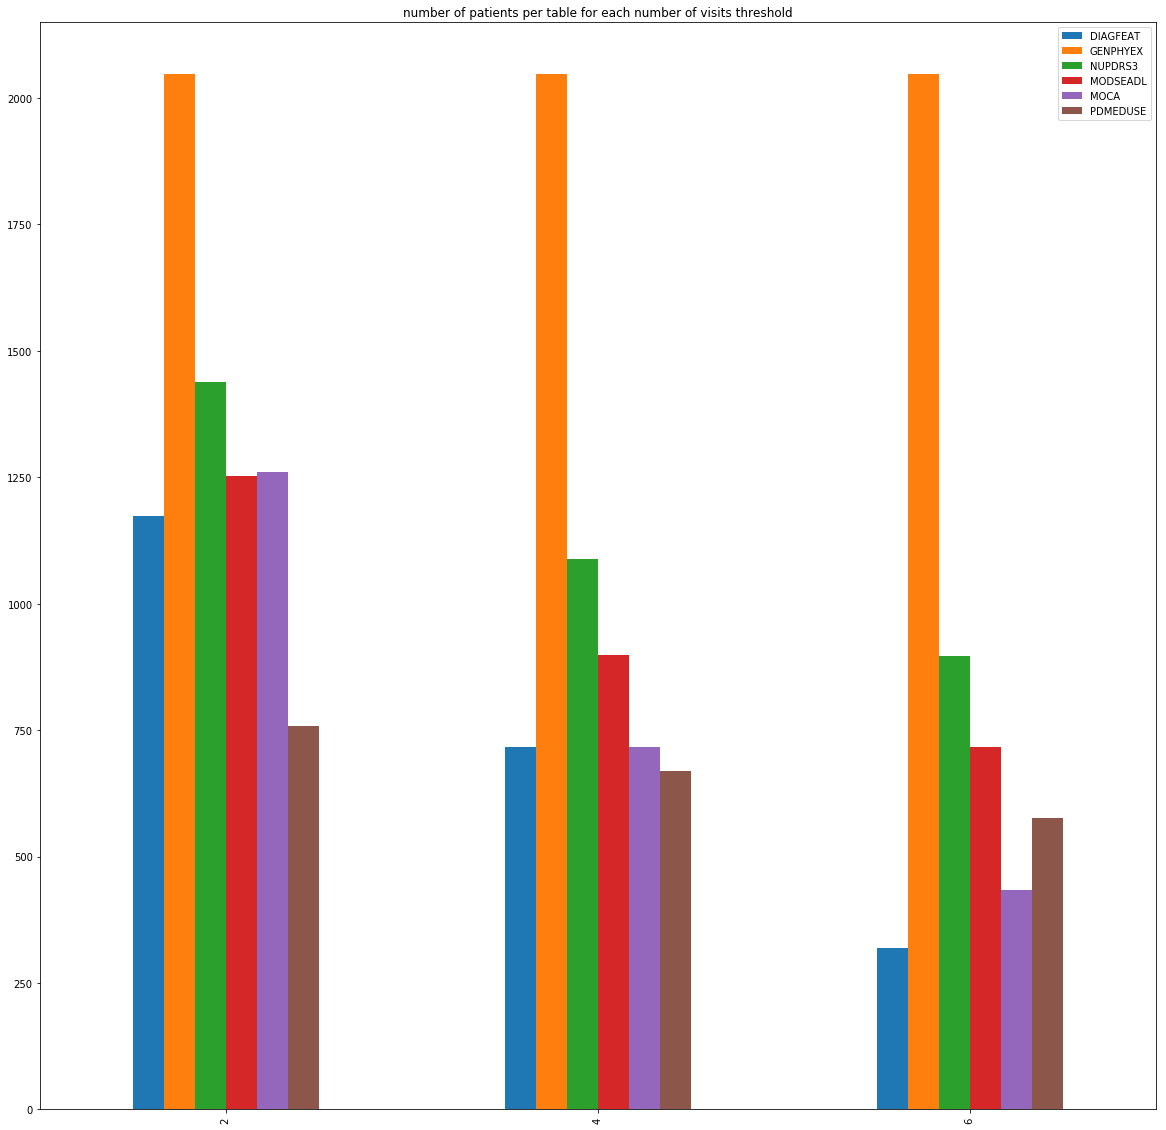

In [19]:
import cufflinks as cf
# Configure it to work offline:
cf.go_offline(connected=True)

dfPlot_patients.plot(kind='bar',
                              #bins=list(dfPlot_patients.index),
                              title='number of patients per table for each number of visits threshold',figsize=(20,20))
                              #xTitle='number of visits thresold',
                            #yTitle='number of patients per table')

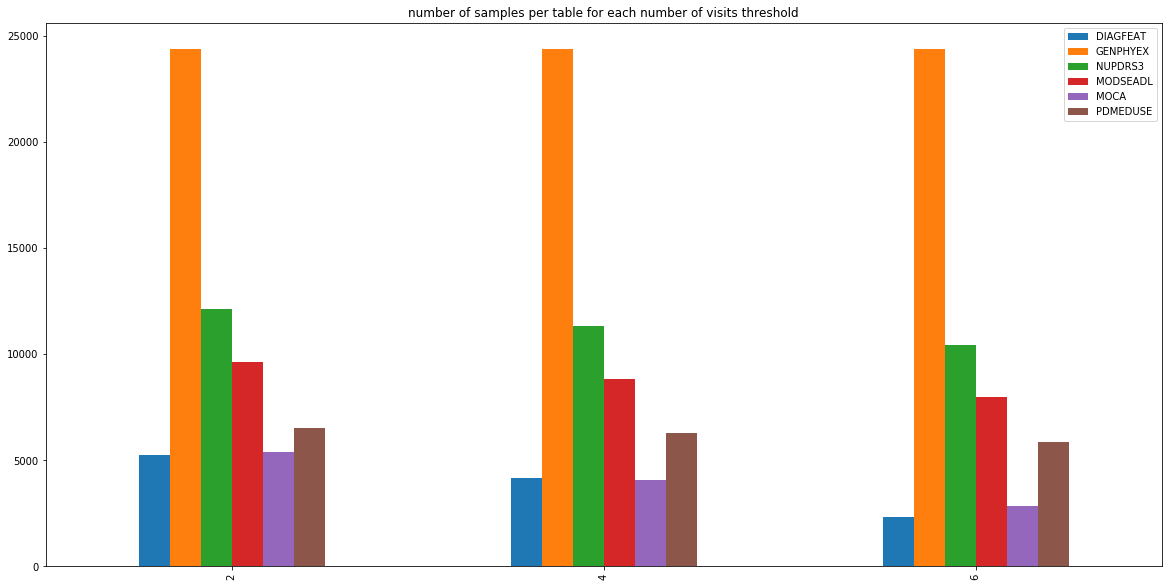

In [22]:
#dfPlot_samples2=dfPlot_samples.drop(columns='GENPHYEX')
dfPlot_samples.plot(kind='bar',
                              #bins=list(df_Plot_samples.index),
                              title='number of samples per table for each number of visits threshold',
                              #xlabel='number of visits thresold',
                            #ylabel='number of samples per table',
                     figsize=(20,10))

### 2. Analysis of variations of number of pads, crops, drops per input_timesteps

In [ ]:
list_df=[DIAGFEAT_sel,MHXGEN_sel,GENPHYEX_sel,PENEURO_sel,PENEURO2_sel,VITAL_sel,
NUPDRS1,NUPDRS2P,NUPDRS3,NUPDRS4,PASE,PASELT,MODSEADL,
UPSIT,EPWORTH,LNSPD,REMSLEEP,COGTIME,SCOPAAUT,COGCATG,HVLT,
MOCA,SFT,GDSSHORT,SDM,STAI,BENTONOD,QUIPCS,PDMEDUSE]

df_names=['DIAGFEAT','MHXGEN','GENPHYEX','PENEURO','PENEURO2','VITAL',
'NUPDRS1','NUPDRS2P','NUPDRS3','NUPDRS4','PASE','PASELT','MODSEADL',
'UPSIT','EPWORTH','LNSPD','REMSLEEP','COGTIME','SCOPAAUT','COGCATG','HVLT',
'MOCA','SFT','GDSSHORT','SDM','STAI','BENTONOD','QUIPCS','PDMEDUSE']

dataset_analysis_maintables0_4_2=table_analysis(list_df,df_names,0)
dataset_analysis_maintables0_5_2=table_analysis(list_df,df_names,0,5)
dataset_analysis_maintables0_6_2=table_analysis(list_df,df_names,0,6)

dataset_analysis_maintables0_4_3=table_analysis(list_df,df_names,0,th_drop=3)
dataset_analysis_maintables0_5_3=table_analysis(list_df,df_names,0,5,3)
dataset_analysis_maintables0_6_3=table_analysis(list_df,df_names,0,6,3)

rowSel=['DIAGFEAT','GENPHYEX','NUPDRS3','MODSEADL','MOCA','PDMEDUSE']
colSel=['drops','pads','crops']

# boucle for with a list of df instead: 
df_4_2=dataset_analysis_maintables0_4_2.loc[rowSel,colSel]
df_5_2=dataset_analysis_maintables0_5_2.loc[rowSel,colSel]
df_6_2=dataset_analysis_maintables0_6_2.loc[rowSel,colSel]

df_4_3=dataset_analysis_maintables0_4_3.loc[rowSel,colSel]
df_5_3=dataset_analysis_maintables0_5_3.loc[rowSel,colSel]
df_6_3=dataset_analysis_maintables0_6_3.loc[rowSel,colSel]

#col_renamed=dict(zip(list(df_to_plot4.columns),['len_patients4','len_df_sel4']))
#df_to_plot4.rename(columns=col_renamed,inplace=True)


df=pd.merge(df_4_2,df_5_2,left_index=True,right_index=True)
df=pd.merge(df,df_6_2,left_index=True,right_index=True)
df=df.T
df['Measure']=np.tile(('drops','pads','crops'),len(colSel))
df['input_timesteps']=np.repeat((4,5,6),len(colSel))
df=df.rename(index=dict(zip(list(df.index),list(df['input_timesteps'].values))))

df2=pd.merge(df_4_3,df_5_3,left_index=True,right_index=True)
df2=pd.merge(df2,df_6_3,left_index=True,right_index=True)
df2=df2.T
df2['Measure']=np.tile(('drops','pads','crops'),len(colSel))
df2['input_timesteps']=np.repeat((4,5,6),len(colSel))
df2=df2.rename(index=dict(zip(list(df2.index),list(df2['input_timesteps'].values))))

list_tables=['DIAGFEAT','GENPHYEX','NUPDRS3','MODSEADL','MOCA','PDMEDUSE']
colors=dict(zip(['drops','pads','crops'],['grey','green','red']))

for i, table in enumerate(list_tables): 
    f=plt.subplot(3, 2, i+1)
    f=sns.barplot(x='input_timesteps',y=table,data=df,hue='Measure',palette=colors)
    f.set_title('{}'.format(table))
    f.figure.set_size_inches(w=30,h=30)
    
plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/'
fig_name='pad_crop_drop_mainTables_thr2.png'
plt_path_name=plt_path_name+fig_name
f.figure.savefig(plt_path_name)
plt.close()

for i, table in enumerate(list_tables): 
    f=plt.subplot(3, 2, i+1)
    f=sns.barplot(x='input_timesteps',y=table,data=df2,hue='Measure',palette=colors)
    f.set_title('{}'.format(table))
    f.figure.set_size_inches(w=30,h=30)

plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/'
fig_name='pad_crop_drop_mainTables_thr3.png'
plt_path_name=plt_path_name+fig_name
f.figure.savefig(plt_path_name)
plt.close()

## Addtionnal (no TS) features

In [ ]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/1-Subject-Characteristics/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Screening__Demographics - useful
#### NOT TS DATA
SCREEN=dict_files[files_names[3]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME',
       'CONSNTDT', 'APPRDX', 'CURRENT_APPRDX', 'P3GRP', 'BIRTHDT', 'GENDER',
       'HISPLAT', 'RAINDALS', 'RAASIAN', 'RABLACK', 'RAHAWOPI', 'RAWHITE',
       'RANOS', 'PRJENRDT']
SCREEN_sel=SCREEN[SEL]

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'PD_Features.csv': useful: Feat-PD - caution: these are actually not timeseries but examination only done at screening (SC), BL & V04
### 1017 patients
PDFEAT=dict_files[files_names[14]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'SXMO',
       'SXYEAR', 'PDDXDT', 'DXTREMOR', 'DXRIGID', 'DXBRADY',
       'DXPOSINS', 'DXOTHSX','DOMSIDE','DOMSIDE']
PDFEAT_sel=PDFEAT[SEL]

## Biospecimen
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/2-Biospecimen/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### Genetic_Results_Tests - useful: Feat-bio - 1116 patients
#### NOT TS DATA

MUTRSLT=dict_files[files_names[3]]
SEL=['REC_ID','PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'GENECAT', 'LRRKCD', 'MUTRSLT']
MUTRSLT_sel=MUTRSLT[SEL]

### Pilot_Biospecimen_Analysis_Results - useful: Feat-bio - 664 patients...
#### Understand if the cohort of patient IDs are different from the classic PPMI cohort.
#### NOT TS DATA.

### Pilot_Biospecimen_Analysis_Results - useful: Feat-bio
Biospecimen_Analysis=dict_files[files_names[6]]

SEL=['PATNO', 'DIAGNOSIS', 'CLINICAL_EVENT', 'TYPE', 'TESTNAME',
       'TESTVALUE','RUNDATE', 'PROJECTID']
Biospecimen_Analysis_sel=Biospecimen_Analysis[SEL]

### Lumbar_Puncture_Sample_Collection - useful: Feat-bio - 1344 patients
LUMBAR=dict_files[files_names[9]]

### Only features useful I think: white cell blood count, red blood cell count, total glucose, total protein.

SEL=['REC_ID','PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT','CSFSPNRT',
     'SMPDSCRD','RBCRSLT','WBCRSLT','TOPRRSLT','TGLCRSLT']
LUMBAR_sel=LUMBAR[SEL]

### Additionnal feature: PRIMDX. 

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/3-Enrollment/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### 'Primary_Diagnosis.csv' - useful: Feat-Gen - 789 patients... (only PD patients?)
PRIMDXPD=dict_files[files_names[8]]

SEL=['REC_ID', 'F_STATUS', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'PRIMDIAG']
print(number_of_patients(PRIMDXPD))
PRIMDXPD_sel=PRIMDXPD[SEL]

### 'Prodromal_Diagnostic_Questionnaire.csv': useful: Feat-Gen (PRIMDIAG & PSLVL2) 
#### NB: PSLV2 evaluates the proba of the patient being PD: might be useful for early PD. But not to be used in the main analysis as a feature (only for Prodromal & Genetic Cohort - i.e 800 subjects) 

folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/5-Medical-History/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

PRODIAG=dict_files[files_names[0]]
SEL=['REC_ID', 'F_STATUS', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'PRIMDIAG', 'PSLVL2']
PRODIAG_sel=PRODIAG[SEL]

Prodromal=set(PRODIAG['PATNO'])
PrimdxPat=set(PRIMDXPD['PATNO'])
intersect=list(Prodromal or PrimdxPat)

### GOOD NEWS!! : PRODROMA AND PRIMDX CAN BE CONCATENATED!!!!! (different set of patients)

## 4-Imaging - dataset not to be used for the time being.
### Info about Imaging Data pages 98 to 101 in the study protocol. 

In [ ]:
folder_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018/4-Imaging/'
files_names=reading_csv_files(folder_path)[1]
dict_files=reading_csv_files(folder_path)[2]

### FBB_Analysis_Data.csv
FBBANAL=dict_files[files_names[0]]
# no selection to do. 

### AV-133_Imaging.csv
AVIMAG=dict_files[files_names[2]]
SEL=['REC_ID','PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PETCMPLT','VMATRSLT']
AVIMAG_sel=AVIMAG[SEL]

### DaTscan_Imaging.csv
DATSCAN=dict_files[files_names[3]]
DATSCAN.columns
SEL=['REC_ID','PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'DATSCAN','VSINTRPT','VSRPTELG']
DATSCAN_sel=DATSCAN[SEL]

### AV-133_SBR_Results.csv
ind_av133_sbr=dict_files[files_names[5]]
col_old=list(ind_av133_sbr.columns)
col_new=['PATNO',
 'EVENT_ID',
 'INFODT',
 'TIMEPOINT',
 'RCAUD-S',
 'RPUTANT-S',
 'RPUTPOST-S',
 'LCAUD-S',
 'LPUTANT-S',
 'LPUTPOST-S',
 'update_stamp']
col=dict(zip(col_old,col_new))
ind_av133_sbr.rename(columns=col,inplace=True)
SEL=['PATNO', 'EVENT_ID', 'INFODT', 'RCAUD-S', 'RPUTANT-S',
       'RPUTPOST-S', 'LCAUD-S', 'LPUTANT-S', 'LPUTPOST-S']
ind_av133_sbr_sel=ind_av133_sbr[SEL]

### Magnetic_Resonance_Imaging.csv
MRI=dict_files[files_names[6]]
SEL=['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'MRICMPLT', 'MRIWDTI', 'MRIWRSS', 'MRIRSLT',
       'PDMEDYN', 'ONLDOPA', 'ONDOPAG']
MRI_sel=MRI[SEL]

### DTI_Regions_of_Interest
DTIROI=dict_files[files_names[7]]
SEL=['PATNO', 'PAG_NAME', 'INFODT', 'Measure','ROI1', 'ROI2',
       'ROI3', 'ROI4', 'ROI5', 'ROI6', 'REF1', 'REF2']
DTIROI_sel=DTIROI[SEL]

### DaTSCAN_SPECT_Visual_Interpretation_Assessment.csv - not found in data dictionary...
SPECT_vis_assess=dict_files[files_names[8]]
#SPECT_vis_assess.head()

In [ ]:
list_df=[FBBANAL,AVIMAG_sel,DATSCAN_sel,ind_av133_sbr_sel,MRI_sel,DTIROI_sel]
df_names=['FBBANAL','AVIMAG','DATSCAN','ind_av133_sbr','MRI','DTIROI']
dataset_analysis_imaging=table_analysis(list_df,df_names,threshold=3) #threshold=3 to have more 
#dataset_analysis_imaging

In [ ]:
list_df=[PDMEDUSE_sel,CURRCOND_sel,SURGPD_sel]
df_names=['PDMEDUSE','CURRCOND','SURGPD']
dataset_analysis_meds=table_analysis(list_df,df_names)